Dependencies:<br>
- Pls make sure u create a 'cGAN' folder in the same directory as this file to save weights
- pip/conda install any missing modules (especially tensorflow_addons)

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import math
# from tqdm.notebook import tqdm
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D
import tensorflow_addons as tfa

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [2]:
from keras.datasets.cifar10 import load_data

(X_train, y_train), (_, _) = load_data()

In [3]:
# data_augmentation = tf.keras.Sequential([
#   tf.image.random_flip_left_right(),
#   tfa.image.rotate(20),
# ])

# def data_augmentation(data):
#     imageArr = []
#     for images in data:
#         image = tf.image.random_flip_left_right(images),
#         image = tfa.image.rotate(images=image, angles=20)
#         imageArr.append(image)
#     return imageArr

with tf.device('/CPU:0'):
  X_train_aug = tf.image.random_flip_left_right(X_train)
  X_train_aug = tfa.image.rotate(images=X_train_aug, angles=20)
  X_train = np.concatenate((X_train, X_train_aug), axis=0)

  if X_train.shape[0] > 50000:
      y_train = np.concatenate((y_train, y_train), axis=0)

In [4]:
class_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

NUM_CLASS = 10

y_train = to_categorical(y_train)
pre_processing_v1 = Normalization()
pre_processing_v1.adapt(X_train)
X_train = X_train.astype('float32')
X_train /= (255/2)
X_train -= 1

In [5]:
noise = 128

# function to create generator model
def create_improve_cGAN_generator(noise):

    # gaussian weights initialization
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # latent noise vector z
    z = Input(shape=(noise,), name="Latent_Noise_Vector_z")

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    # Generator network
    merged_layer = Concatenate()([z, conditions])

    # FC: 2x2x512
    generator = Dense(2*2*512, activation='relu')(merged_layer)
    generator = BatchNormalization(momentum=0.8)(generator)
    generator = PReLU()(generator)
    generator = Reshape((2, 2, 512))(generator)

    base_generator = Sequential([
        # Conv 1: 4x4x256
        SpectralNormalization(Conv2DTranspose(256, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 2: 8x8x128
        SpectralNormalization(Conv2DTranspose(128, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 3: 16x16x64
        SpectralNormalization(Conv2DTranspose(64, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
    ], name='Base_Generator')
    generator = base_generator(generator)

    # Conv 4: 32x32x3
    generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',
                                activation='tanh', name='Output_Layer')(generator)

    generator = Model(inputs=[z, conditions],
                      outputs=generator,  name='generator_cGAN')
    return generator

In [6]:
# function to create discriminator model
def create_improve_cGAN_discriminator(image_size):
    # input image
    img_input = Input(shape=(image_size), name='Image_Input')
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    base_discriminator = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(128, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(512, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
    ], name='Base_Discriminator')
    discriminator = base_discriminator(img_input)

    discriminator = GlobalAveragePooling2D()(discriminator)

    # Concatenate - combine with conditions y
    merged_layer = Concatenate()([discriminator, conditions])
    discriminator = Dense(512, activation='relu')(merged_layer)

    # Output
    discriminator = Dense(1, activation='sigmoid',
                          name='Output_Layer')(discriminator)

    discriminator = Model(inputs=[img_input, conditions],
                          outputs=discriminator, name='discriminator_cGAN')
    return discriminator

In [7]:
class NewcGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=20, noise=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.noise = noise
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.latent_noise_vector = tf.random.normal(
            shape=(self.num_img, self.noise))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                          0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict(
            [self.latent_noise_vector, self.conditions])
        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(class_labels[i % 10])
            ax.axis('off')
        plt.show()

    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name = 'cGAN/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')


In [8]:
callbacks = [
    NewcGANMonitor(num_img=20, noise=128, patience=5, vmin=-1, vmax=1),
]


In [9]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, noise):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise = noise
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(
            name="discriminator_loss")
        # self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        # self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        # self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data

        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator(
                [combined_images, combined_condition])
            d_loss = self.loss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # # Computing D(x|y)
        # d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])
            g_loss = self.loss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        # # Computing D(G(z|y))
        # d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),

        }

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(



1/1 [==============================] - 0s 262ms/step


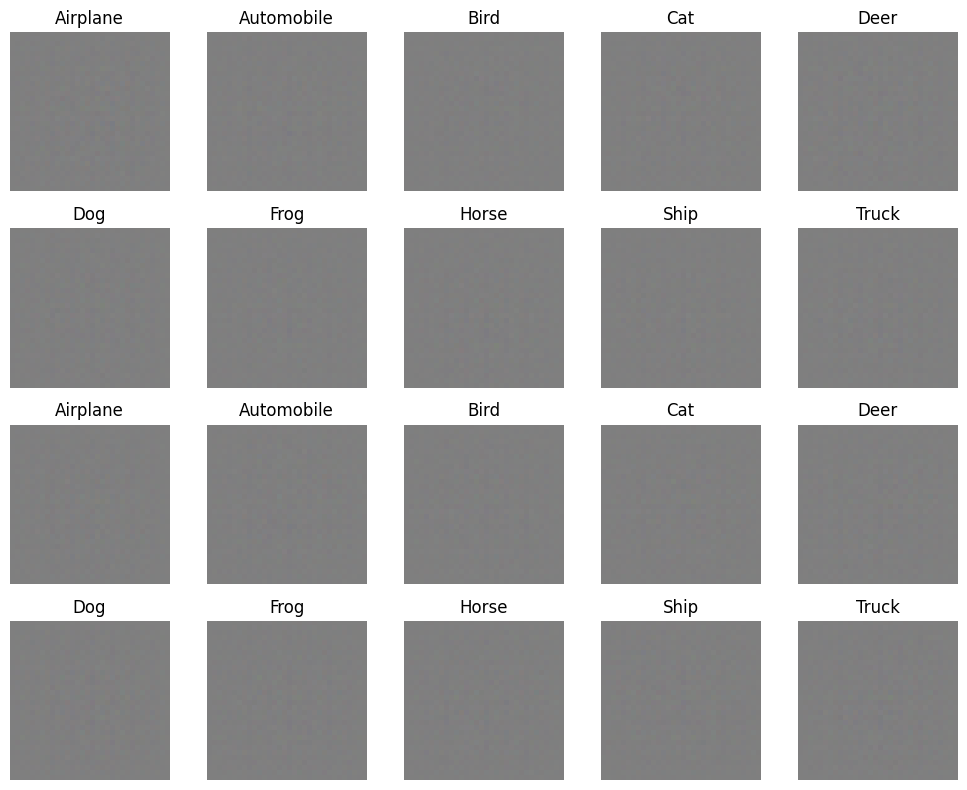

Generator Checkpoint - cGAN/generator-epoch-0.h5
Epoch 1/100
1563/1563 [==============================] - 271s 171ms/step - d_loss: 0.3171 - g_loss: 2.6095
Epoch 2/100
1563/1563 [==============================] - 261s 167ms/step - d_loss: 0.2469 - g_loss: 2.9898
Epoch 3/100
1563/1563 [==============================] - 255s 163ms/step - d_loss: 0.2664 - g_loss: 3.3773
Epoch 4/100
1563/1563 [==============================] - 278s 178ms/step - d_loss: 0.3073 - g_loss: 2.8399
Epoch 5/100
1/1 [==============================] - 0s 24ms/step


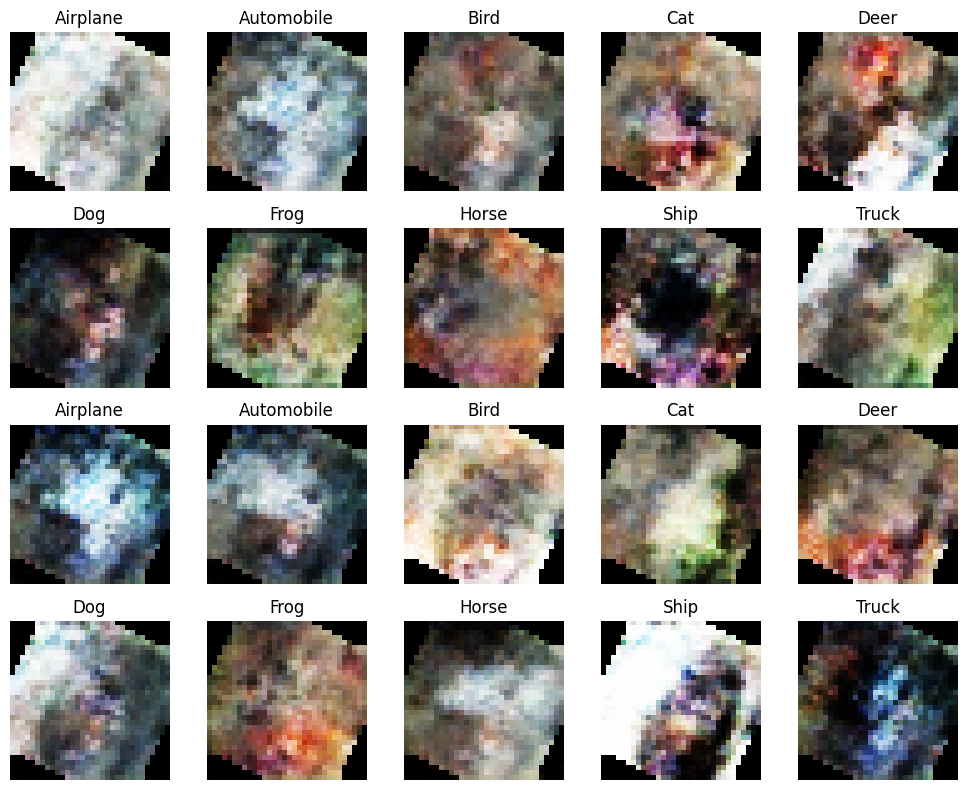

Generator Checkpoint - cGAN/generator-epoch-5.h5
Epoch 6/100
1563/1563 [==============================] - 265s 169ms/step - d_loss: 0.2650 - g_loss: 3.1013
Epoch 7/100
1563/1563 [==============================] - 279s 178ms/step - d_loss: 0.1906 - g_loss: 3.9199
Epoch 8/100
1563/1563 [==============================] - 271s 173ms/step - d_loss: 0.1097 - g_loss: 4.6977
Epoch 9/100
1563/1563 [==============================] - 263s 168ms/step - d_loss: 0.1644 - g_loss: 4.2129
Epoch 10/100
1/1 [==============================] - 0s 23ms/step


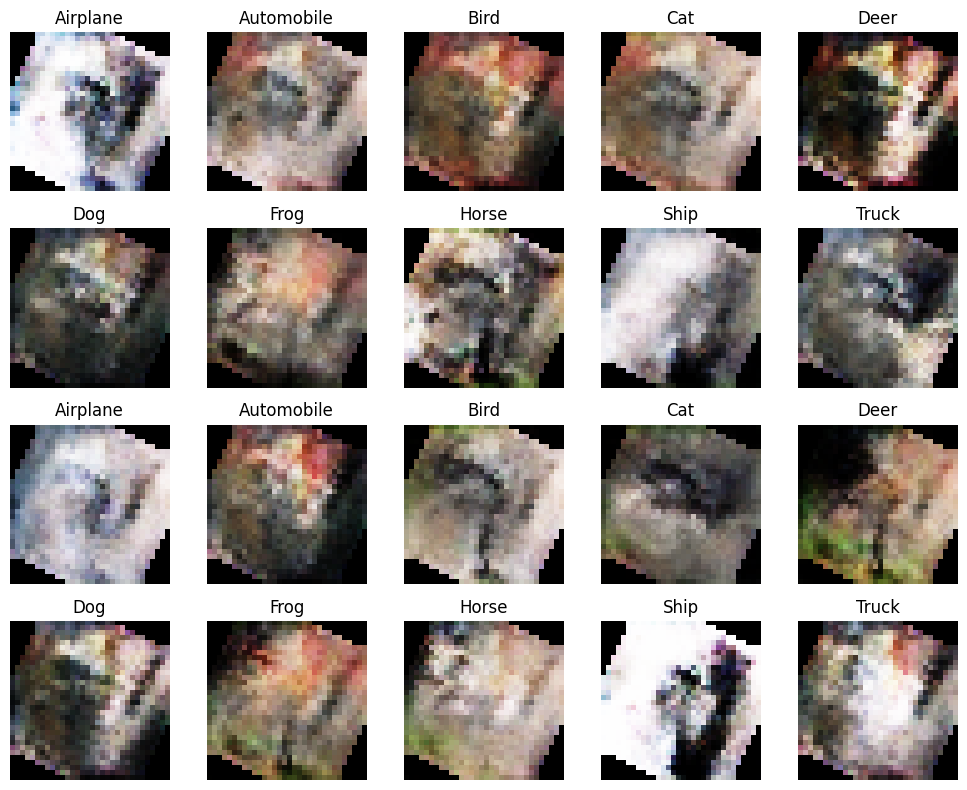

Generator Checkpoint - cGAN/generator-epoch-10.h5
Epoch 11/100
1563/1563 [==============================] - 239s 153ms/step - d_loss: 0.1117 - g_loss: 4.6874
Epoch 12/100
1563/1563 [==============================] - 232s 149ms/step - d_loss: 0.0820 - g_loss: 5.2204
Epoch 13/100
1563/1563 [==============================] - 233s 149ms/step - d_loss: 0.1270 - g_loss: 4.5358
Epoch 14/100
1563/1563 [==============================] - 242s 155ms/step - d_loss: 0.1197 - g_loss: 4.9705
Epoch 15/100
1/1 [==============================] - 0s 21ms/step


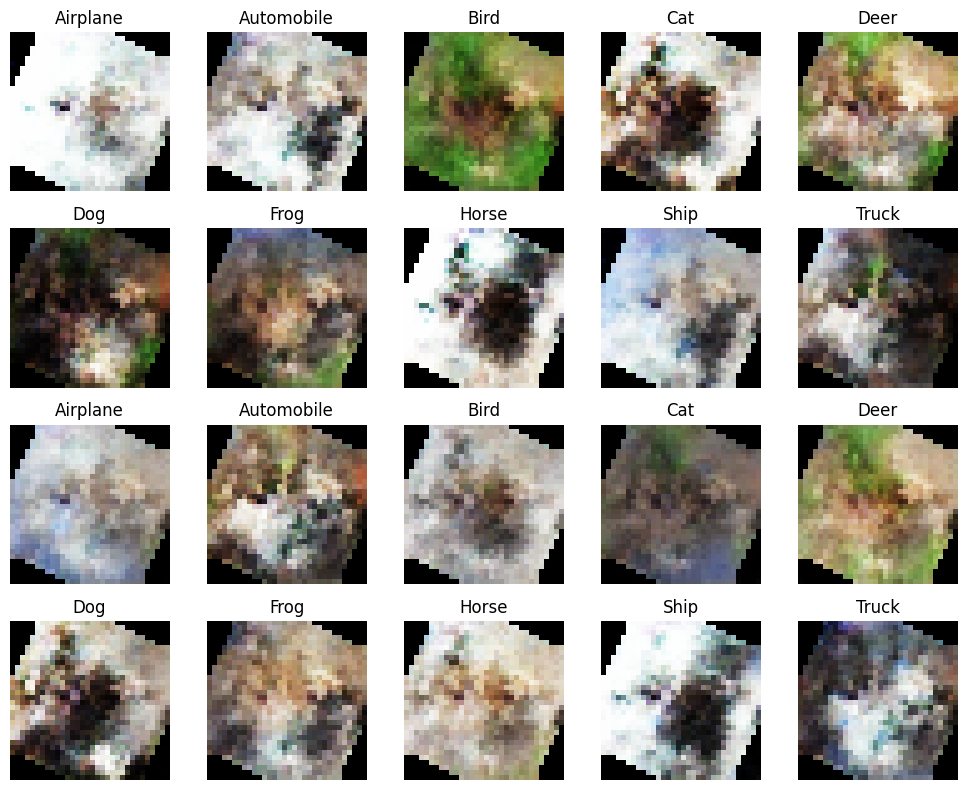

Generator Checkpoint - cGAN/generator-epoch-15.h5
Epoch 16/100
1563/1563 [==============================] - 203s 130ms/step - d_loss: 0.1005 - g_loss: 4.9189
Epoch 17/100
1563/1563 [==============================] - 206s 132ms/step - d_loss: 0.0812 - g_loss: 5.5279
Epoch 18/100
1563/1563 [==============================] - 205s 131ms/step - d_loss: 0.1241 - g_loss: 4.6364
Epoch 19/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0850 - g_loss: 5.2545
Epoch 20/100
1/1 [==============================] - 0s 23ms/step


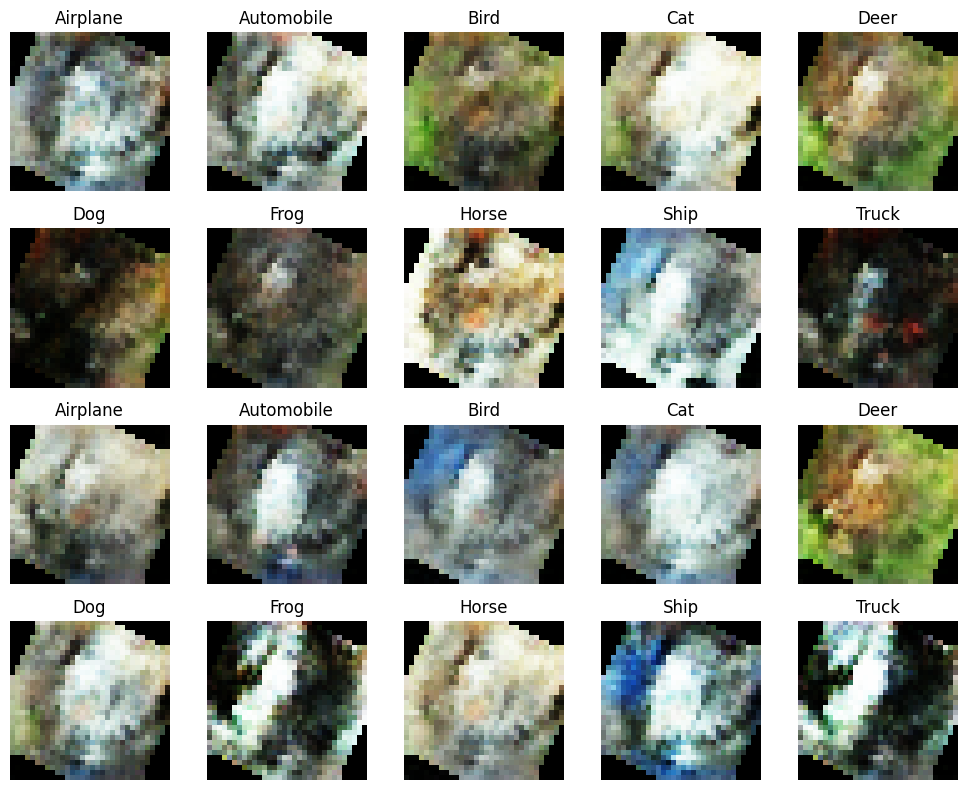

Generator Checkpoint - cGAN/generator-epoch-20.h5
Epoch 21/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0751 - g_loss: 5.2290
Epoch 22/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1235 - g_loss: 4.5248
Epoch 23/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0734 - g_loss: 5.8046
Epoch 24/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0942 - g_loss: 4.9918
Epoch 25/100
1/1 [==============================] - 0s 22ms/step


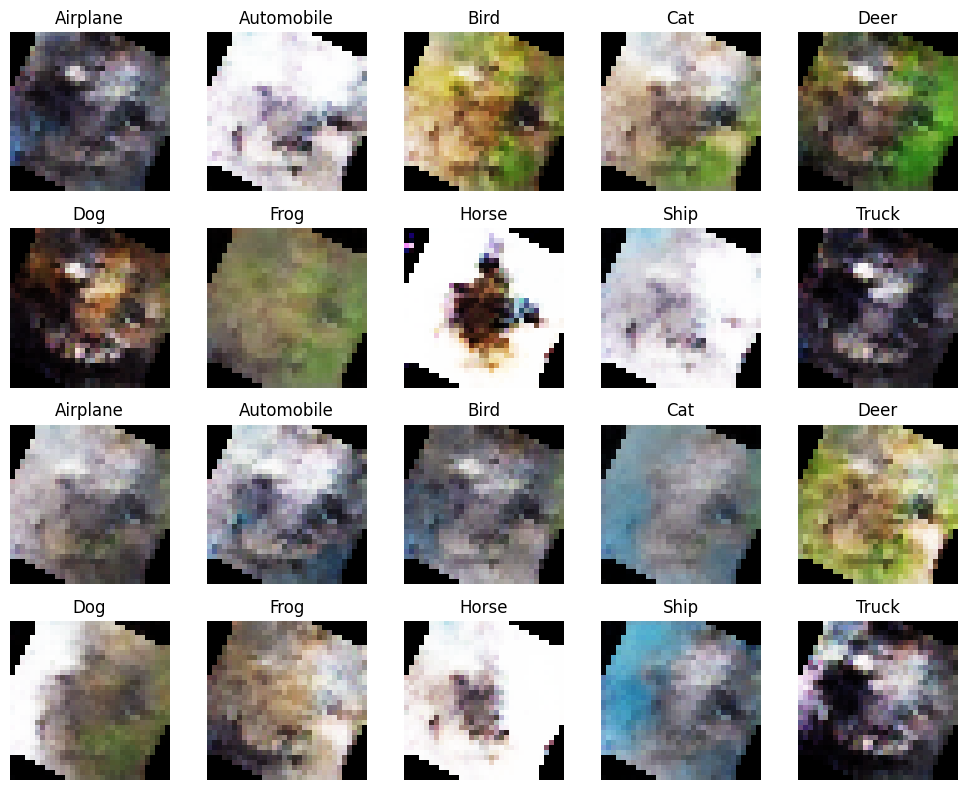

Generator Checkpoint - cGAN/generator-epoch-25.h5
Epoch 26/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0494 - g_loss: 5.8495
Epoch 27/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1489 - g_loss: 4.5174
Epoch 28/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0758 - g_loss: 5.2089
Epoch 29/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0884 - g_loss: 4.9796
Epoch 30/100
1/1 [==============================] - 0s 21ms/step


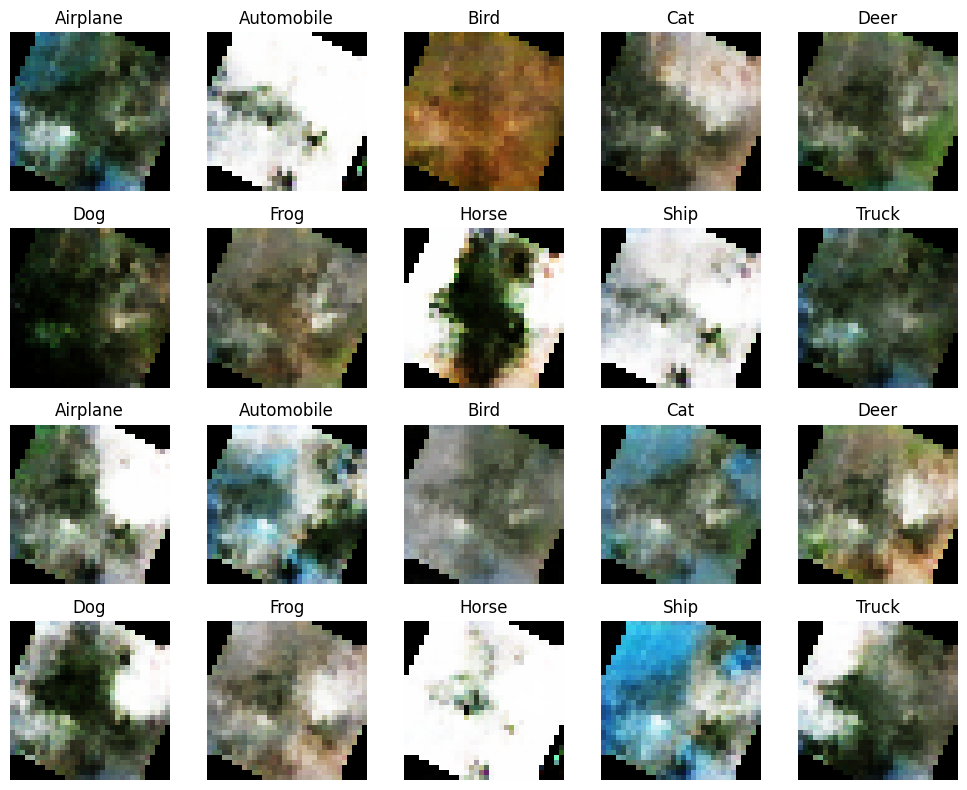

Generator Checkpoint - cGAN/generator-epoch-30.h5
Epoch 31/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0734 - g_loss: 5.3067
Epoch 32/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0980 - g_loss: 5.3373
Epoch 33/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0648 - g_loss: 5.4548
Epoch 34/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1365 - g_loss: 4.7138
Epoch 35/100
1/1 [==============================] - 0s 21ms/step


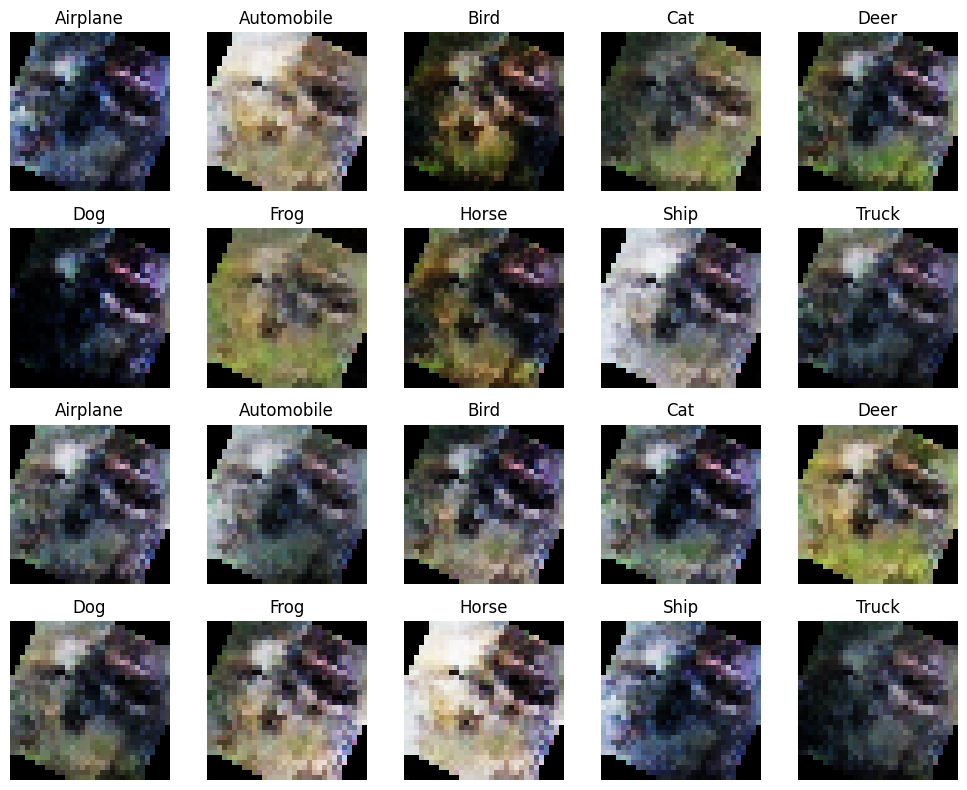

Generator Checkpoint - cGAN/generator-epoch-35.h5
Epoch 36/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1238 - g_loss: 5.5383
Epoch 37/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0479 - g_loss: 5.4373
Epoch 38/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1155 - g_loss: 5.4544
Epoch 39/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0668 - g_loss: 5.9794
Epoch 40/100
1/1 [==============================] - 0s 21ms/step


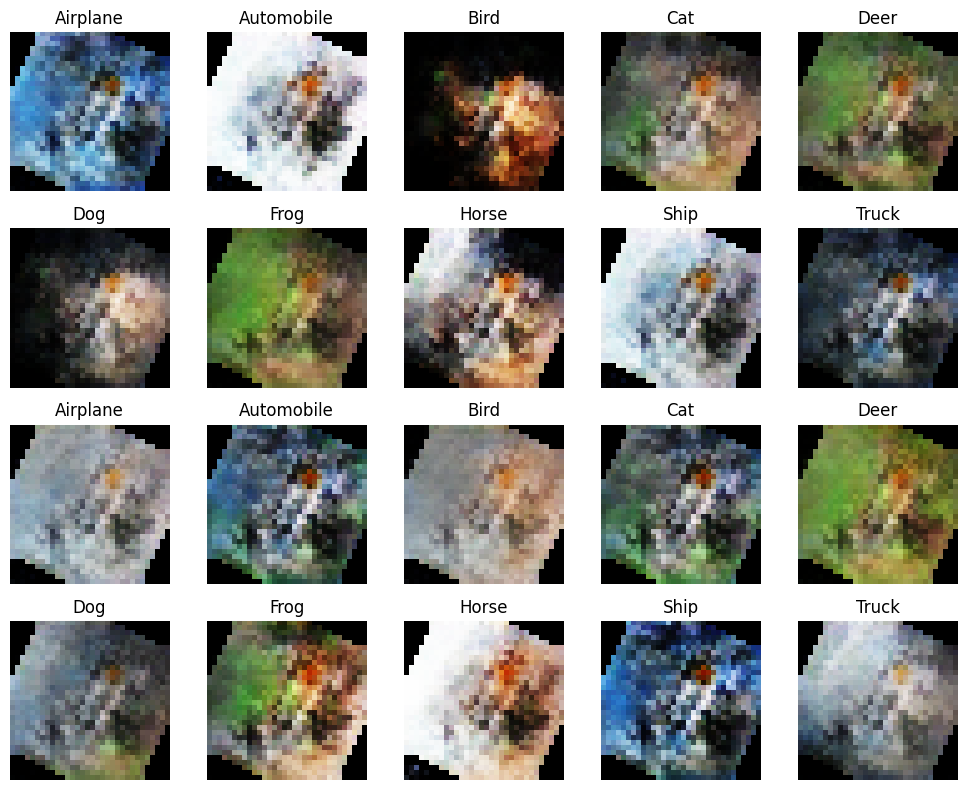

Generator Checkpoint - cGAN/generator-epoch-40.h5
Epoch 41/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0742 - g_loss: 5.9768
Epoch 42/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0439 - g_loss: 6.1081
Epoch 43/100
1563/1563 [==============================] - 201s 128ms/step - d_loss: 0.0879 - g_loss: 7.3174
Epoch 44/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0688 - g_loss: 6.0845
Epoch 45/100
1/1 [==============================] - 0s 21ms/step


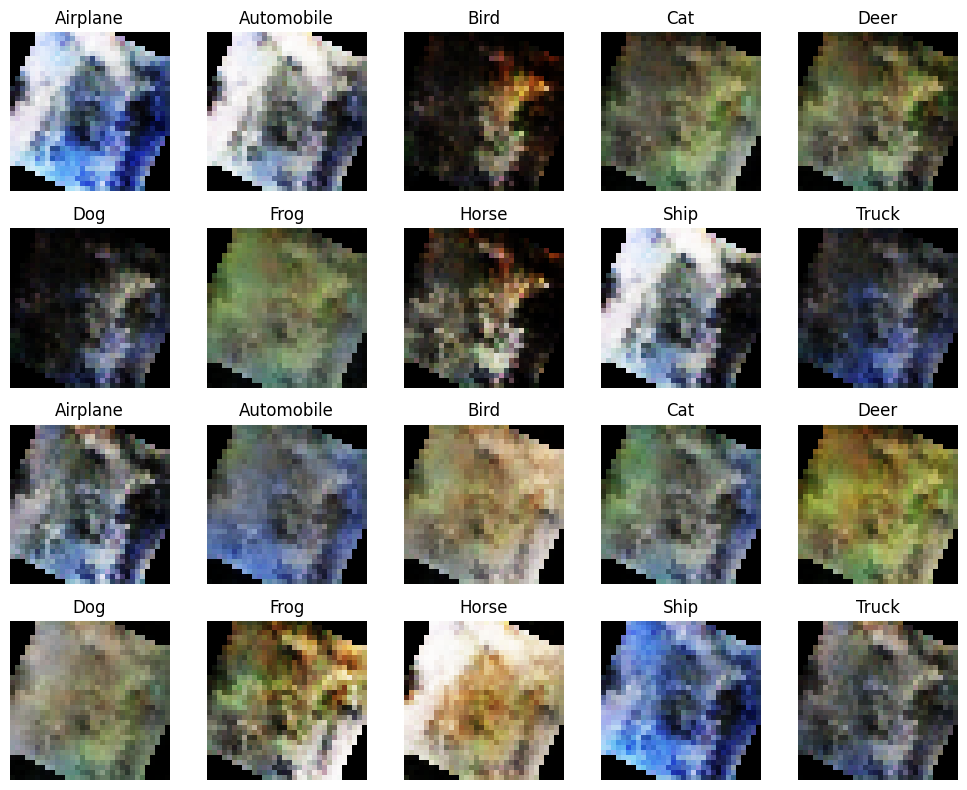

Generator Checkpoint - cGAN/generator-epoch-45.h5
Epoch 46/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0649 - g_loss: 5.6138
Epoch 47/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0491 - g_loss: 6.0011
Epoch 48/100
1563/1563 [==============================] - 203s 130ms/step - d_loss: 0.1404 - g_loss: 5.8868
Epoch 49/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0578 - g_loss: 5.6777
Epoch 50/100
1/1 [==============================] - 0s 21ms/step


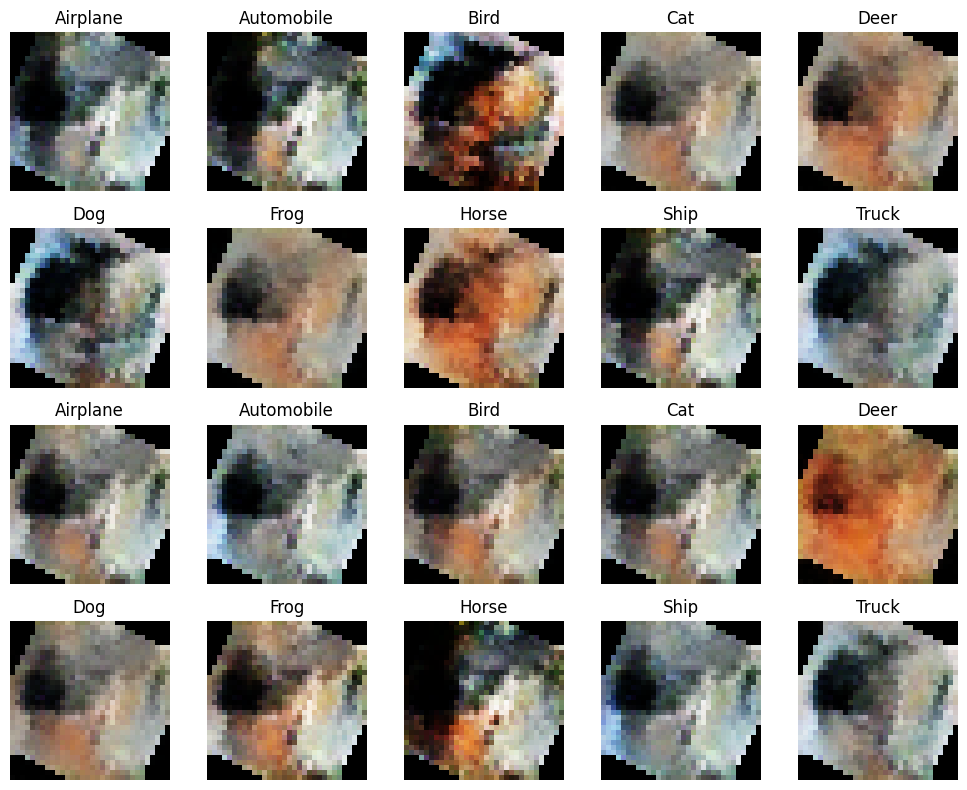

Generator Checkpoint - cGAN/generator-epoch-50.h5
Epoch 51/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0615 - g_loss: 6.1326
Epoch 52/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0489 - g_loss: 5.9012
Epoch 53/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1005 - g_loss: 6.0093
Epoch 54/100
1563/1563 [==============================] - 201s 128ms/step - d_loss: 0.0659 - g_loss: 5.5788
Epoch 55/100
1/1 [==============================] - 0s 21ms/step


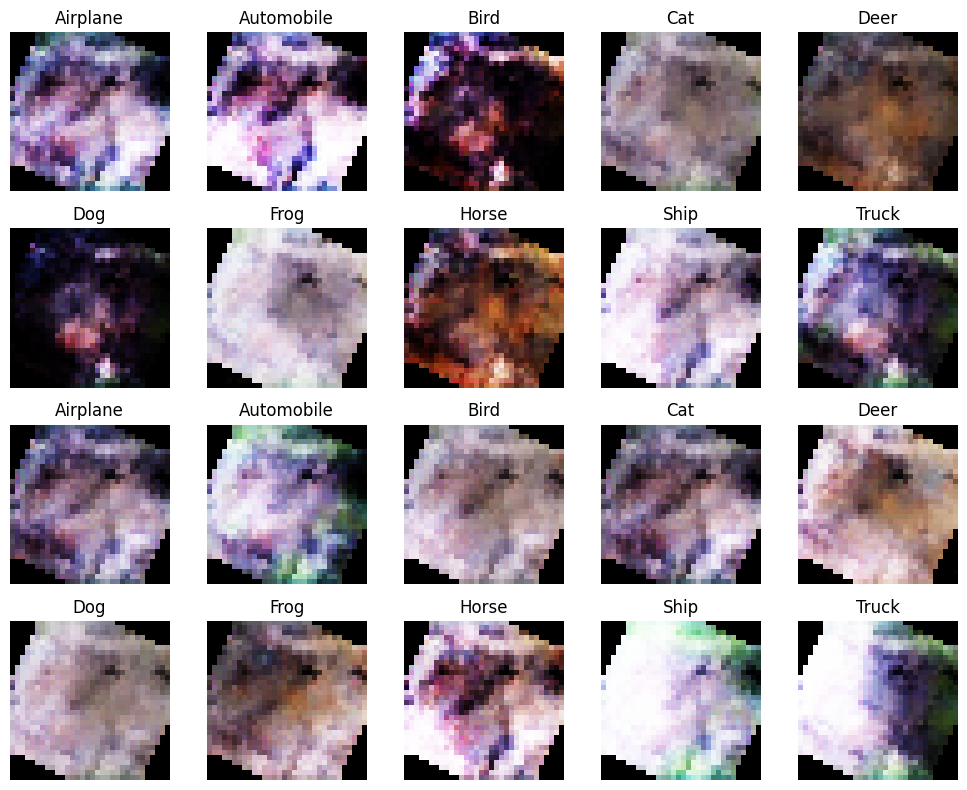

Generator Checkpoint - cGAN/generator-epoch-55.h5
Epoch 56/100
1563/1563 [==============================] - 201s 128ms/step - d_loss: 0.0561 - g_loss: 6.2426
Epoch 57/100
1563/1563 [==============================] - 201s 128ms/step - d_loss: 0.0459 - g_loss: 6.1570
Epoch 58/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0555 - g_loss: 6.0098
Epoch 59/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1021 - g_loss: 6.1860
Epoch 60/100
1/1 [==============================] - 0s 28ms/step


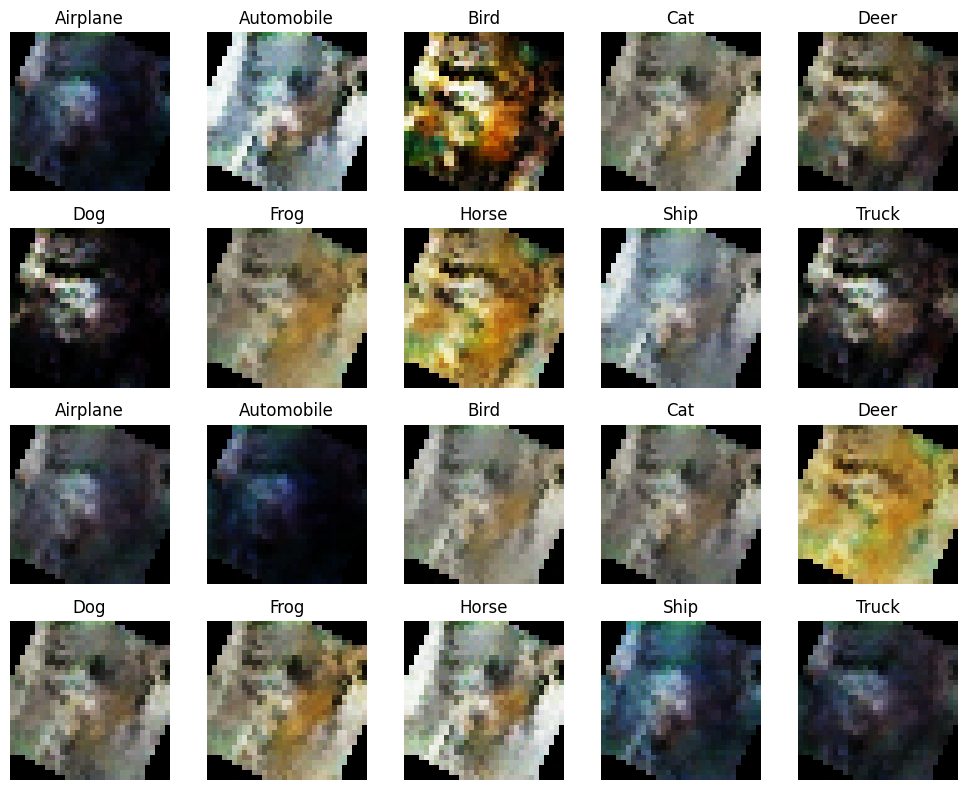

Generator Checkpoint - cGAN/generator-epoch-60.h5
Epoch 61/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0702 - g_loss: 5.3150
Epoch 62/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0404 - g_loss: 6.4685
Epoch 63/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0552 - g_loss: 6.1617
Epoch 64/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0561 - g_loss: 6.5431
Epoch 65/100
1/1 [==============================] - 0s 22ms/step


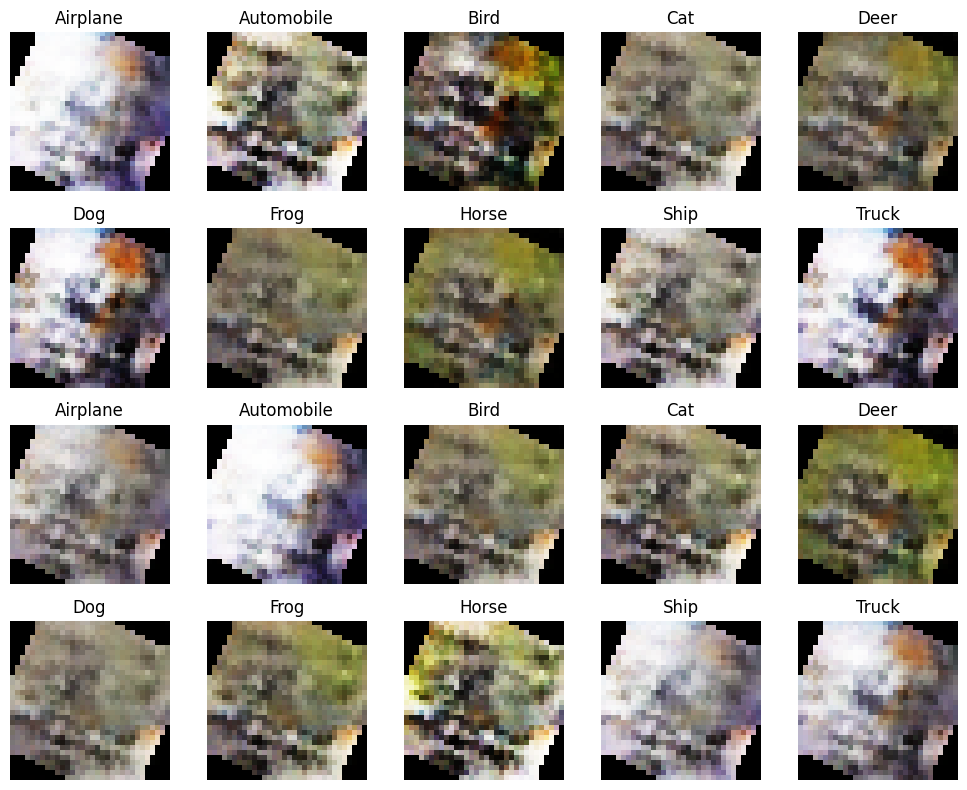

Generator Checkpoint - cGAN/generator-epoch-65.h5
Epoch 66/100
1563/1563 [==============================] - 204s 130ms/step - d_loss: 0.1026 - g_loss: 6.3532
Epoch 67/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0585 - g_loss: 8.7428
Epoch 68/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0447 - g_loss: 6.0986
Epoch 69/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0431 - g_loss: 6.0725
Epoch 70/100
1/1 [==============================] - 0s 21ms/step


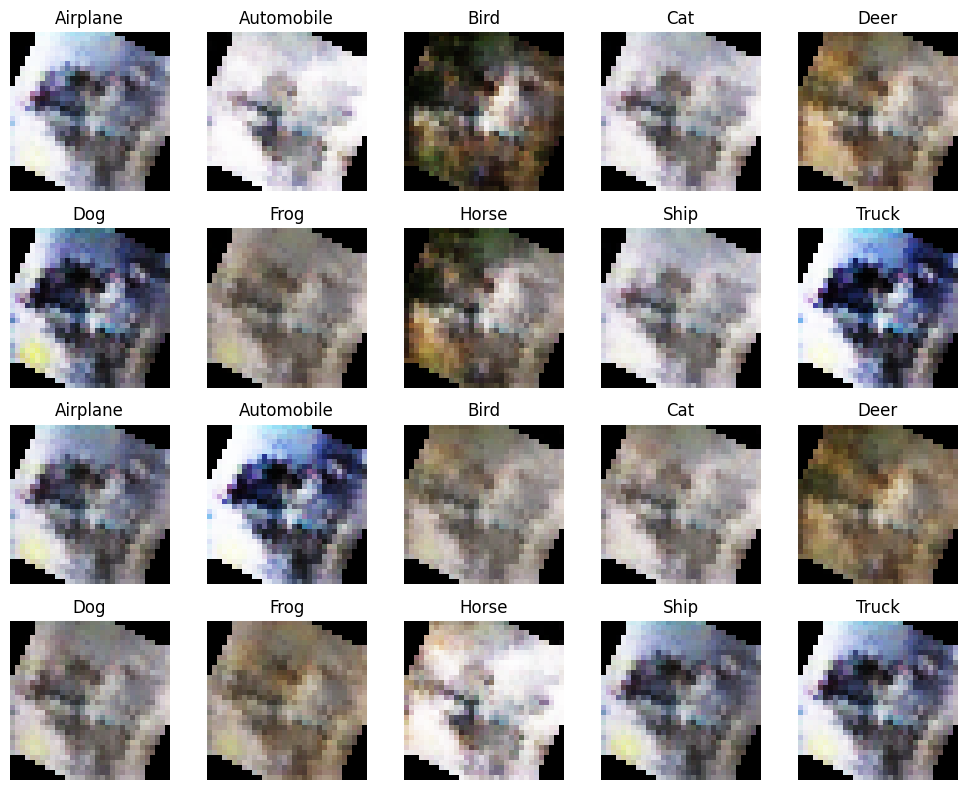

Generator Checkpoint - cGAN/generator-epoch-70.h5
Epoch 71/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0590 - g_loss: 6.4080
Epoch 72/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0248 - g_loss: 9.4830
Epoch 73/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0485 - g_loss: 8.5505
Epoch 74/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0592 - g_loss: 8.2600
Epoch 75/100
1/1 [==============================] - 0s 22ms/step


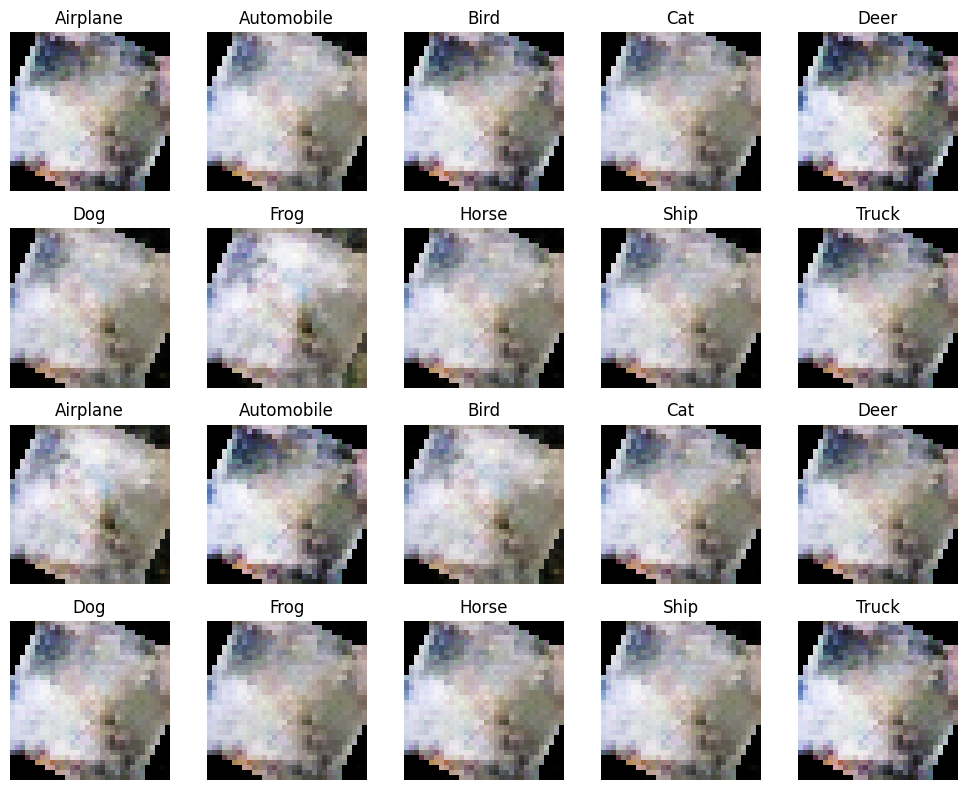

Generator Checkpoint - cGAN/generator-epoch-75.h5
Epoch 76/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.1324 - g_loss: 6.7011
Epoch 77/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1657 - g_loss: 7.2652
Epoch 78/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1207 - g_loss: 8.2751
Epoch 79/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0638 - g_loss: 7.8760
Epoch 80/100
1/1 [==============================] - 0s 21ms/step


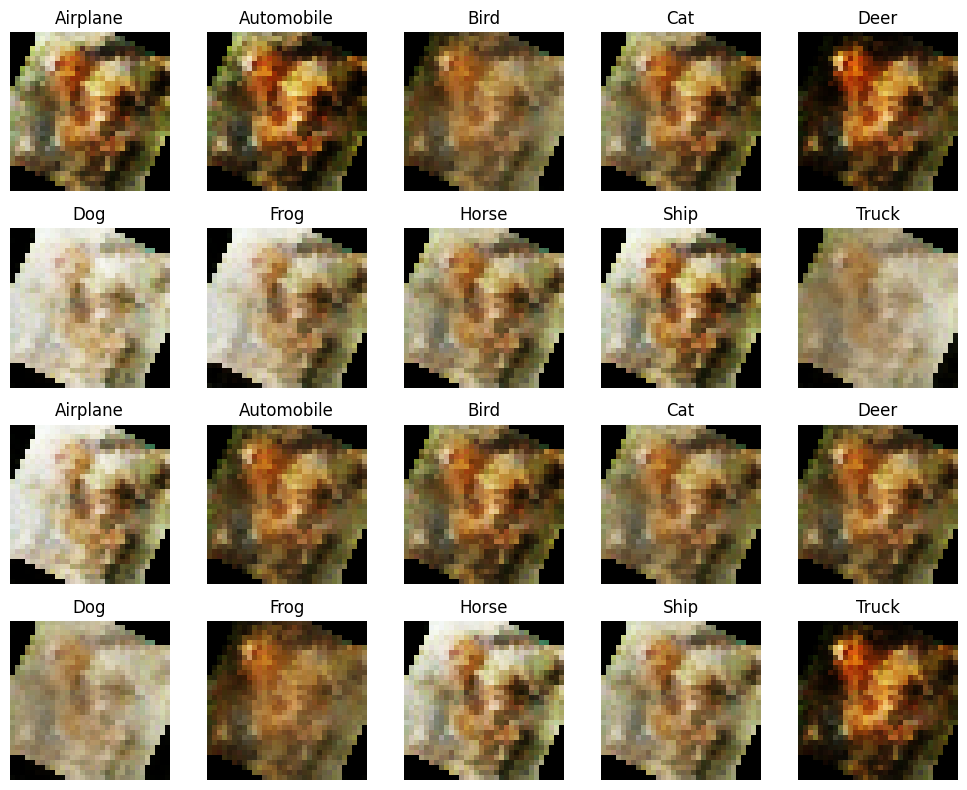

Generator Checkpoint - cGAN/generator-epoch-80.h5
Epoch 81/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0490 - g_loss: 7.3502
Epoch 82/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0413 - g_loss: 7.1605
Epoch 83/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0611 - g_loss: 9.3842
Epoch 84/100
1563/1563 [==============================] - 203s 130ms/step - d_loss: 0.0652 - g_loss: 8.1673
Epoch 85/100
1/1 [==============================] - 0s 20ms/step


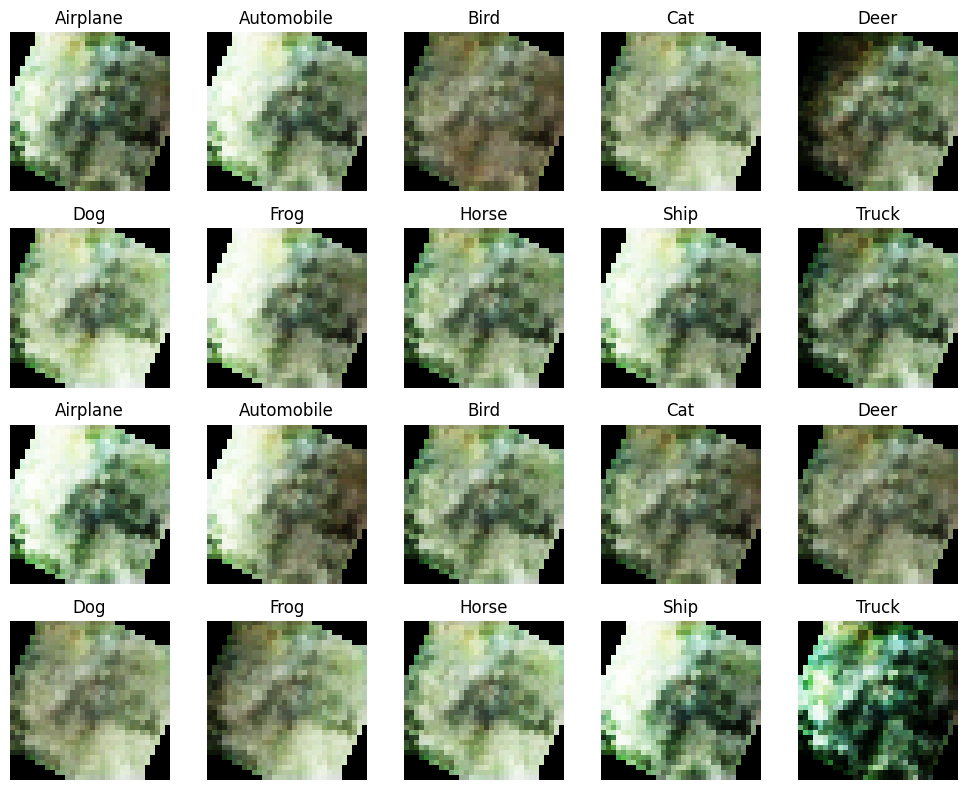

Generator Checkpoint - cGAN/generator-epoch-85.h5
Epoch 86/100
1563/1563 [==============================] - 201s 128ms/step - d_loss: 0.0581 - g_loss: 10.4491
Epoch 87/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1098 - g_loss: 9.3969
Epoch 88/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0506 - g_loss: 6.1842
Epoch 89/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0349 - g_loss: 7.9111
Epoch 90/100
1/1 [==============================] - 0s 23ms/step


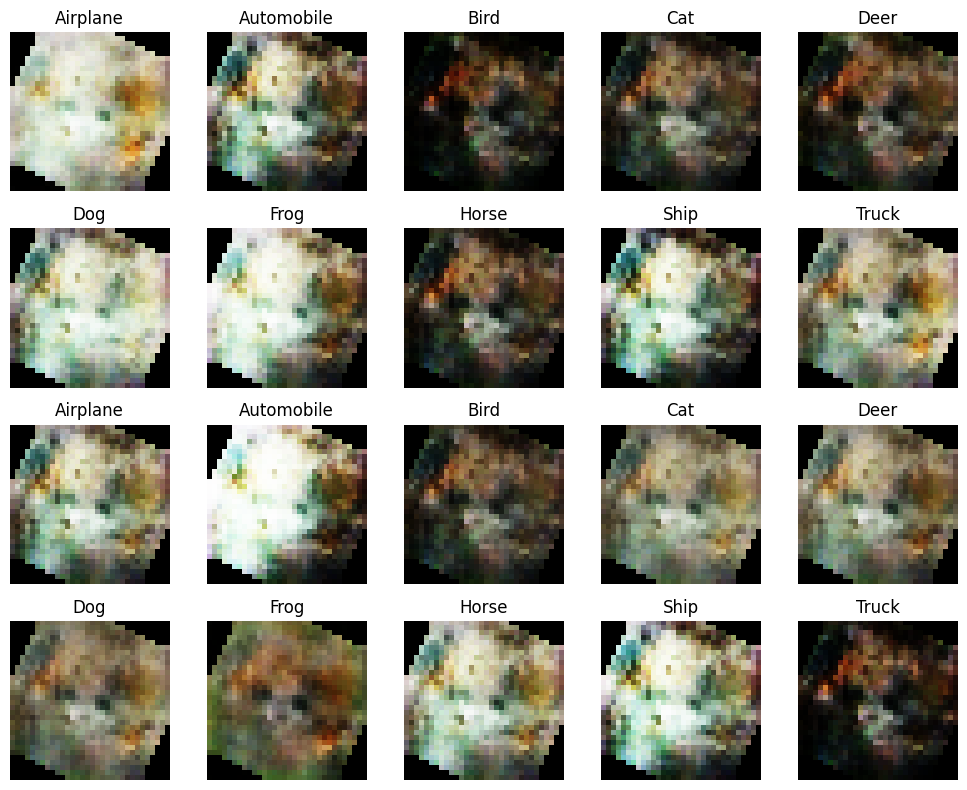

Generator Checkpoint - cGAN/generator-epoch-90.h5
Epoch 91/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0438 - g_loss: 7.1744
Epoch 92/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0943 - g_loss: 7.3341
Epoch 93/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0469 - g_loss: 7.0244
Epoch 94/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.0444 - g_loss: 8.7987
Epoch 95/100
1/1 [==============================] - 0s 24ms/step


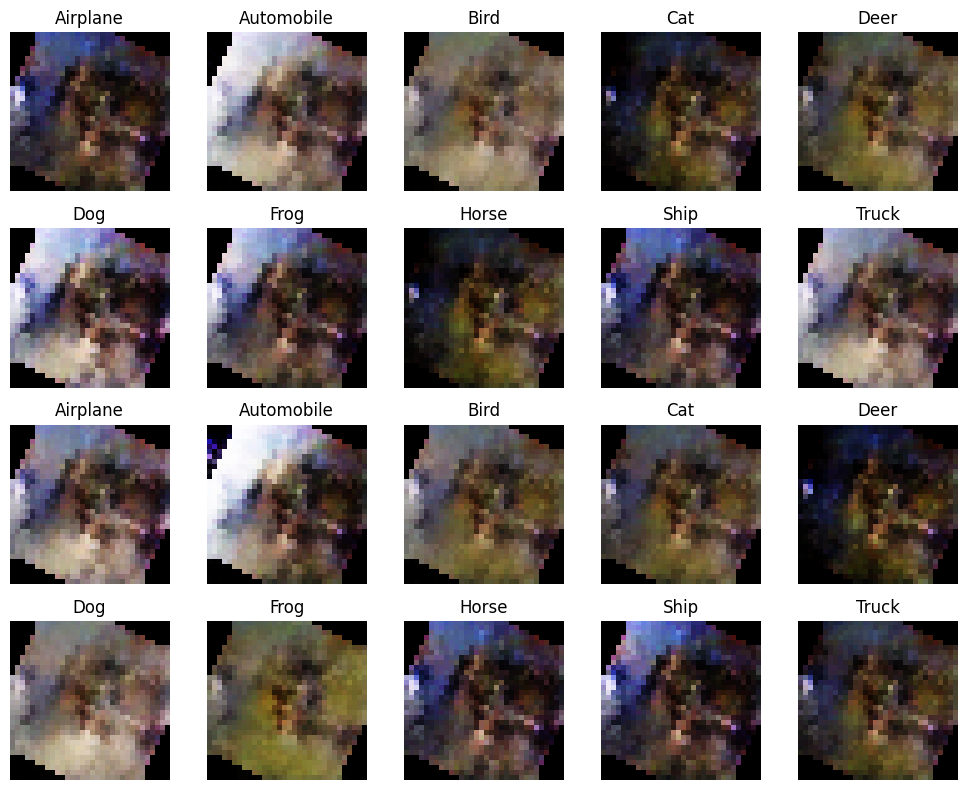

Generator Checkpoint - cGAN/generator-epoch-95.h5
Epoch 96/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0672 - g_loss: 8.8331
Epoch 97/100
1563/1563 [==============================] - 201s 128ms/step - d_loss: 0.0450 - g_loss: 6.7369
Epoch 98/100
1563/1563 [==============================] - 202s 129ms/step - d_loss: 0.0391 - g_loss: 7.0802
Epoch 99/100
1563/1563 [==============================] - 201s 129ms/step - d_loss: 0.1397 - g_loss: 6.3906
Epoch 100/100
1/1 [==============================] - 0s 20ms/step


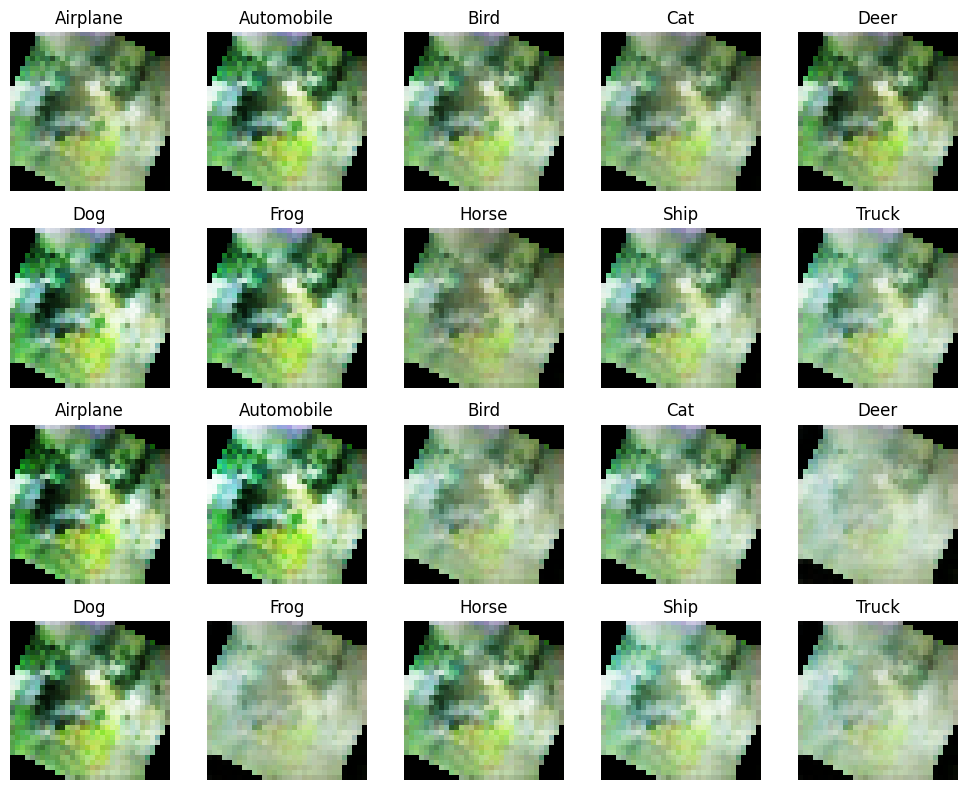

Generator Checkpoint - cGAN/generator-epoch-Full Train.h5


In [10]:
improve_cond_gan = ConditionalGAN(
    discriminator=create_improve_cGAN_discriminator(image_size=(32, 32, 3)),
    generator=create_improve_cGAN_generator(noise=128),
    noise=128
)

improve_cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(
    64, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

improve_cond_gan_hist = improve_cond_gan.fit(
    dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)